Select images from ADNI2 and ADNI3 for preprocessing. These will include images with a corresponding diagnosis as either cognitively normal or Alzheimer's Disease.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import os
import glob
import matplotlib.pyplot as plt

QC information is sourced from the Mayo Clinic-provided QC table. 

In [2]:
# QC for ADNI2 and Go
dfAdni2Go = pd.read_csv('MAYOADIRL_MRI_IMAGEQC_12_08_15.csv', low_memory=False)
dfAdni2Go.columns = [s.upper() for s in dfAdni2Go.columns]
dfT1w2Go = dfAdni2Go.loc[dfAdni2Go['SERIES_TYPE'] == 'T1']

# QC for ADNI3
dfAdni3 = pd.read_csv('MAYOADIRL_MRI_QUALITY_ADNI3.csv')
dfT1w3 = dfAdni3.loc[dfAdni3['SERIES_TYPE'] == 'MT1']

# Summary table including diagnosis
dfInfo = pd.read_csv('ADNIMERGE.csv', low_memory=False)

<AxesSubplot:xlabel='SERIES_QUALITY', ylabel='count'>

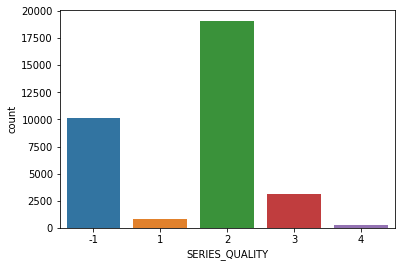

In [3]:
sns.countplot(data=dfAdni2Go, x='SERIES_QUALITY')

<AxesSubplot:xlabel='SERIES_QUALITY', ylabel='count'>

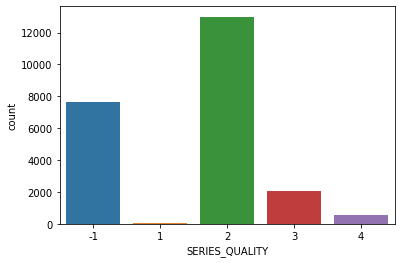

In [4]:
sns.countplot(data=dfAdni3, x='SERIES_QUALITY')

Keep images with quality rating of 1 or 2

In [5]:
print('ADNI2/Go')
print(dfT1w2Go.shape[0], 'T1w images')
dfT1w2GoGood = dfT1w2Go.loc[dfT1w2Go['SERIES_QUALITY'].isin([1, 2])].copy()
print(dfT1w2GoGood.shape[0], 'excellent or good-rated images')

print('ADNI3')
print(dfT1w3.shape[0], 'T1w images')
dfT1w3Good = dfT1w3.loc[dfT1w3['SERIES_QUALITY'].isin([1, 2])].copy()
print(dfT1w3Good.shape[0], 'excellent or good-rated images')

ADNI2/Go
8551 T1w images
7681 excellent or good-rated images
ADNI3
2276 T1w images
1904 excellent or good-rated images


In [6]:
# Convert date strings into datetime objects
dfInfo['PARSED_DATE'] = [dt.datetime.strptime(str(d), '%Y-%m-%d') for d in dfInfo['EXAMDATE']]
dfInfo['PARSED_DATE']

dfT1w2GoGood['PARSED_DATE'] = [dt.datetime.strptime(str(d), '%Y%m%d') for d in dfT1w2GoGood['SERIES_DATE']]
dfT1w3Good['PARSED_DATE'] = [dt.datetime.strptime(str(d.split(' ')[0]), '%Y-%m-%d') for d in dfT1w3Good['SERIES_DATE']]

For each image, find the temporally closest diagnosis.

In [62]:
def find_dx(df):
    dfOut = pd.DataFrame(columns=['RID', 'Study', 'ScanDate', 'Site', 'DX_Scan', 
                                  'DaysFrom_Scan'])
    i = 0
    for _, row in df.iterrows():
        rid = row['RID']
        scandate = row['PARSED_DATE']
        dfSubjectInfo = dfInfo.loc[dfInfo['RID'] == rid]
        if dfSubjectInfo.shape[0] == 0:
            continue
        
        # Fill in any missing diagnoses, if 
        # 1) diagnoses at previous and following visits are the same. OR
        # 2) previous visit had a dementia diagnosis (let's assume no regression)
        dfSubjectInfo = dfSubjectInfo.sort_values('PARSED_DATE')
        dfForwardFill = dfSubjectInfo['DX'].fillna(method='ffill')
        dfBackFill = dfSubjectInfo['DX'].fillna(method='bfill')
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            dfFillable = dfSubjectInfo['DX'].isna().values \
                & ((dfForwardFill == dfBackFill).values | (dfForwardFill == 'Dementia').values)

        dfSubjectInfo.loc[dfFillable, 'DX'] = dfForwardFill.loc[dfFillable]
        
        # Find nearest visit to imaging date
        idxScan = (dfSubjectInfo['PARSED_DATE'] - scandate).abs().idxmin()
        strDiagScan = dfSubjectInfo.loc[idxScan, 'DX']
        # Compute distance from imaging date
        distScan = dfSubjectInfo['PARSED_DATE'].loc[idxScan] - scandate
        site = dfSubjectInfo['SITE'].loc[idxScan]
        study = dfSubjectInfo['COLPROT'].loc[idxScan]
                
        dfOut.loc[i] = [rid, study, scandate, site, strDiagScan, distScan]
        i += 1
    return dfOut

dfScanDX2Go = find_dx(dfT1w2GoGood)
dfScanDX3 = find_dx(dfT1w3Good)
    

Reject any images without a corresponding diagnosis within 3 months of imaging date. Count remaining images.

In [63]:
# ADNIGo not converted to BIDS yet, we will ignore and focus on ADNI2 and 3
dfScans = pd.concat([dfScanDX2Go.loc[dfScanDX2Go['Study'] == 'ADNI2'], 
                     dfScanDX3], axis=0)
# Remove duplicate scans (e.g. when multiple scans were acquired in the same session)
dfScans = dfScans.loc[~dfScans[['RID', 'ScanDate']].duplicated()]
dfScans.reset_index(inplace=True, drop=True)

# Reject any images where a diagnosis was not found within 3 months of imaging date
dfScans.loc[dfScans['DaysFrom_Scan'].abs() <= dt.timedelta(days=int(30.4 * 3))]

# Count AD and CN images
dfScansAD = dfScans.loc[dfScans['DX_Scan'] == 'Dementia'].copy()
print(dfScansAD.shape[0], 'AD images')
print(dfScansAD['RID'].unique().shape[0], 'unique subjects')

dfScansCN = dfScans.loc[dfScans['DX_Scan'] == 'CN'].copy()
print(dfScansCN.shape[0], 'CN images')
print(dfScansCN['RID'].unique().shape[0], 'unique subjects')

794 AD images
342 unique subjects
1998 CN images
711 unique subjects


Find matching locally downloaded images

In [64]:
dictStudyRoots = {'ADNI2': '/archive/bioinformatics/DLLab/STUDIES/ADNI2_20201008/source',
                  'ADNIGO': '/archive/bioinformatics/DLLab/STUDIES/ADNIGO_20201106/source',
                  'ADNI3': '/archive/bioinformatics/DLLab/STUDIES/ADNI3_20201006/source'}
dfScans['T1w_Path'] = None
for idx, row in dfScans.iterrows():
    strDate = dt.datetime.strftime(dfScans.loc[idx, 'ScanDate'], '%Y%m%d')
    strImgTemplate = os.path.join(dictStudyRoots[row['Study']],
                                'sub-{:04d}'.format(int(row['RID'])),
                                'ses-' + strDate ,
                                'anat/*T1w.nii.gz')
    lsMatches = glob.glob(strImgTemplate)
    lsMatches.sort()
    if len(lsMatches) >= 1:
        dfScans.loc[idx, 'T1w_Path'] = lsMatches[0]
    

In [65]:
dfScansValid = dfScans.loc[~dfScans['T1w_Path'].isna()]
dfScansValid = dfScansValid.loc[dfScansValid['DX_Scan'].isin(['Dementia', 'CN'])]
dfScansValid.reset_index(inplace=True, drop=True)

dfScansAD = dfScansValid.loc[dfScansValid['DX_Scan'] == 'Dementia'].copy()
print(dfScansAD.shape[0], 'AD images')
print(dfScansAD['RID'].unique().shape[0], 'unique subjects')

dfScansCN = dfScansValid.loc[dfScansValid['DX_Scan'] == 'CN'].copy()
print(dfScansCN.shape[0], 'CN images')
print(dfScansCN['RID'].unique().shape[0], 'unique subjects')

694 AD images
294 unique subjects
1626 CN images
595 unique subjects


In [66]:
dfScansValid.to_csv('image_list_ad_cn.csv')

Create input files table for DLLabPipeline

In [67]:
dfScansADCN = dfScansValid.loc[dfScansValid['DX_Scan'].isin(['Dementia', 'CN'])]
dfInputFiles = pd.DataFrame({'subject': dfScansADCN['RID'].astype(int).apply(lambda x: f'{x:04d}'),
                             'session': dfScansADCN['ScanDate'].apply(lambda x: dt.datetime.strftime(x, '%Y%m%d')),
                             'run': None,
                             'input_t1w': dfScansADCN['T1w_Path']})
dfInputFiles.reset_index(inplace=True, drop=True)
dfInputFiles.to_csv('sMRI_input_files.csv')

Count images and subjects per site.

Text(0, 0.5, 'Subjects')

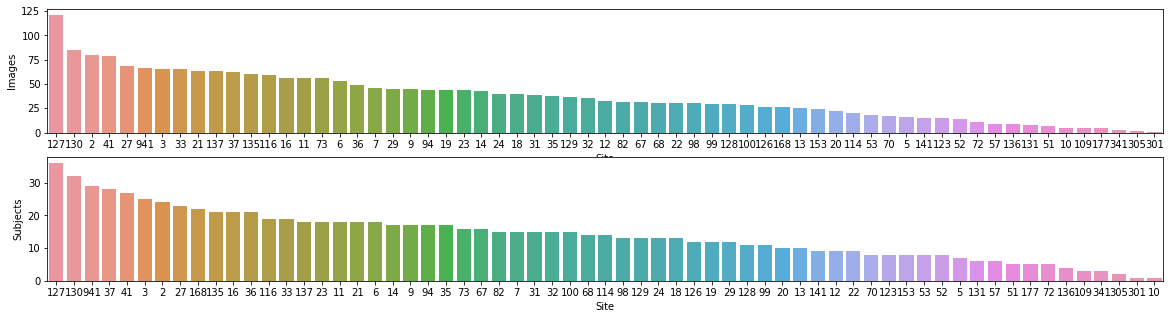

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
sns.countplot(data=dfScansValid, x='Site', order=dfScansValid['Site'].value_counts().index, ax=ax[0])
dfSubjectsValid = dfScansValid[['RID', 'Site']].copy()
dfSubjectsValid = dfSubjectsValid.loc[~dfSubjectsValid['RID'].duplicated()]
sns.countplot(data=dfSubjectsValid, x='Site', order=dfSubjectsValid['Site'].value_counts().index, ax=ax[1])
ax[0].set_ylabel('Images')
ax[1].set_ylabel('Subjects')